# Выбор локации для скважины

**Описание задачи:**

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.    
Требуется:
1. Постройть модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.
2. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков скважин: качество нефти и объём её запасов;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Дополнительные условия:**    

- при разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки;
- бюджет на разработку скважин в регионе — 10 млрд рублей;
- при нынешних ценах один баррель сырья приносит 450 рублей дохода;
- доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей;
- после оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%;
- среди них выбирают регион с наибольшей средней прибылью.

**Описание данных:**

Данные геологоразведки трёх регионов находятся в файлах: 
- **/datasets/geo_data_0.csv**;
- **/datasets/geo_data_1.csv**;
- **/datasets/geo_data_2.csv**.    

Атрибуты скважин:
- **id** — уникальный идентификатор скважины;
- **f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы);
- **product** — объём запасов в скважине (тыс. баррелей).

In [1]:
# устанавливаем нужную версию библиотек
!pip install scikit-learn==1.4

In [2]:
# импортируем все библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    r2_score,
    mean_squared_error
)
# зададим параметры окна вывода графиков
plt.rcParams["figure.figsize"] = (10,7)

## Загрузка и подготовка данных

In [3]:
# загружаем данные по скважинам
#   данные из файла geo_data_0.csv
try:
    geo_data_0 = pd.read_csv('c:/users/bny_7/datasets/geo_data_0.csv', sep=',', decimal='.')
except:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv', decimal='.')

#   данные из файла geo_data_1.csv
try:
    geo_data_1 = pd.read_csv('c:/users/bny_7/datasets/geo_data_1.csv', sep=',', decimal='.')
except:
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv', decimal='.')
    
#   данные из файла geo_data_3.csv    
try:
    geo_data_2 = pd.read_csv('c:/users/bny_7/datasets/geo_data_2.csv', sep=',', decimal='.')
except:
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv', decimal='.')

In [4]:
# проверяем загрузку данных, для этого выводим первые 5 строк из каждого набора на экран
print('Набор данных geo_data_0')
display(geo_data_0.head())
print('Набор данных geo_data_1')
display(geo_data_1.head())
print('Набор данных geo_data_2')
display(geo_data_2.head())

Набор данных geo_data_0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Набор данных geo_data_1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Набор данных geo_data_2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [5]:
# предобработаем данные для исследовательского анализа
# обрабатываем данные набора geo_data_0
display(geo_data_0.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [6]:
# предобработаем данные для исследовательского анализа
# обрабатываем данные набора geo_data_0
display(geo_data_1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [7]:
# предобработаем данные для исследовательского анализа
# обрабатываем данные набора geo_data_0
display(geo_data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

**Выводы по результатам предобработки данных:**     

В каждом из наборов **geo_data_0, geo_data_1, geo_data_2**:
- 100'000 записей;
- пропуски отсутствуют;
- 5 полей: 1 поле с идентификатором скважины (id), 4 поля с численными непрерывными значениями характеристик скважин;
- формат полей соответствует данным, хранящимся в них.     

Дополнительная обработка данных не требуется. Можно переходить к исследовательскому анализу данных.

**Исследовательский анализ данных**

In [8]:
# исследуем данные в наборах на наличие выбросов, а также определим их взаимосвязи
display(geo_data_0.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


На первый взгляд данные в наборах не имеют аномальных значений:    
- данные показателя **f0** принимают значения от **-1.408605 до 2.362331**;
- данные показателя **f1** принимают значения от **-0.848218 до 1.343769**;
- данные показателя **f2** принимают значения от **-12.088328 до 16.003790**;
- данные показателя **product** принимают значения от **0.000000 до 185.364347**.    

Получается, что в каких-то скважинах объем запасов нефти равен 0, что вполне допустимо.     
Построим графики распределения величин, чтобы визуально проверить наличие аномалий.

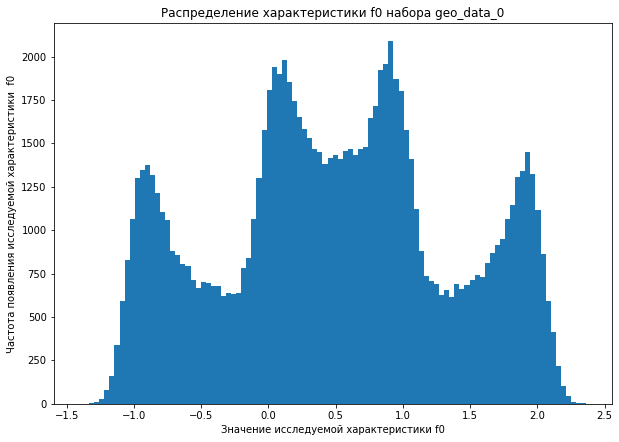

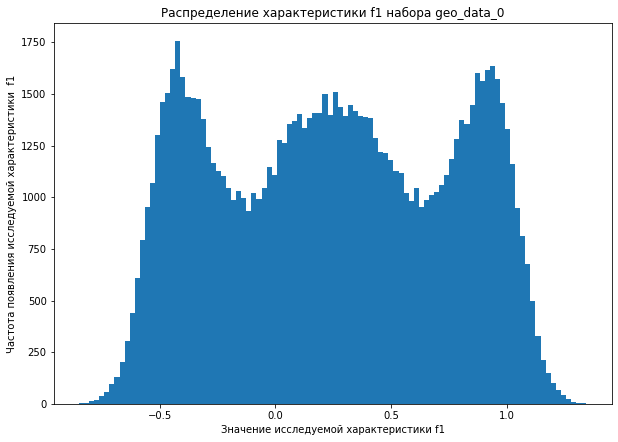

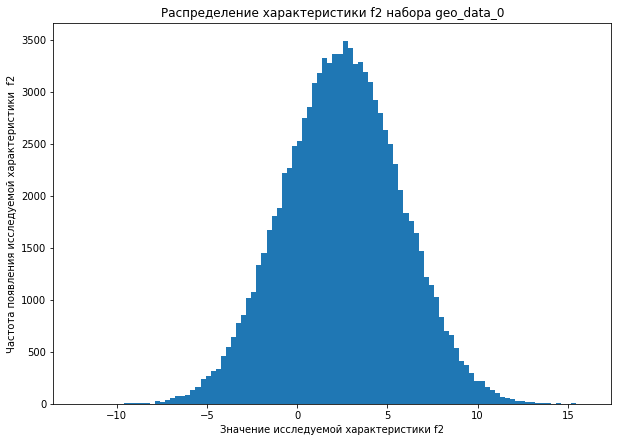

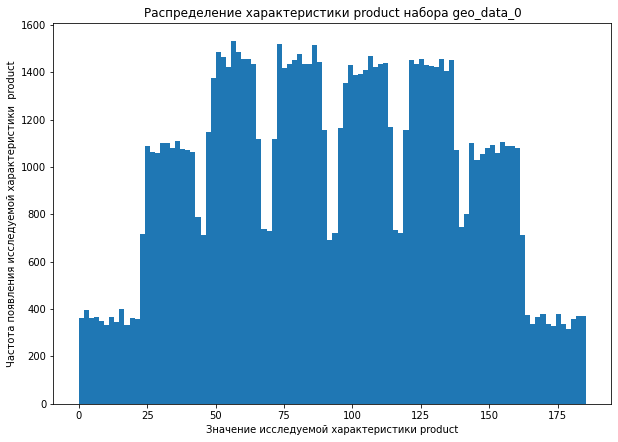

In [9]:
for i in geo_data_0.select_dtypes('float64'):
    ax = geo_data_0[i].plot(kind='hist', bins=100)
    ax.set_title(f'Распределение характеристики {i} набора geo_data_0')
    ax.set_xlabel(f'Значение исследуемой характеристики {i}')
    ax.set_ylabel(f'Частота появления исследуемой характеристики  {i}')
    plt.show()

Из полученных графиков видно:    
- только признак **f2** имеет приемлемое нормальное распределение;
- признаки **f0** и **f1** изменяются волнообразно (*несколько наборов наблюдений свели в одно?*);
- признак **product** скорее имеет нормальное распределение, но с ярко выраженными пиками (*категориальный признак?*).

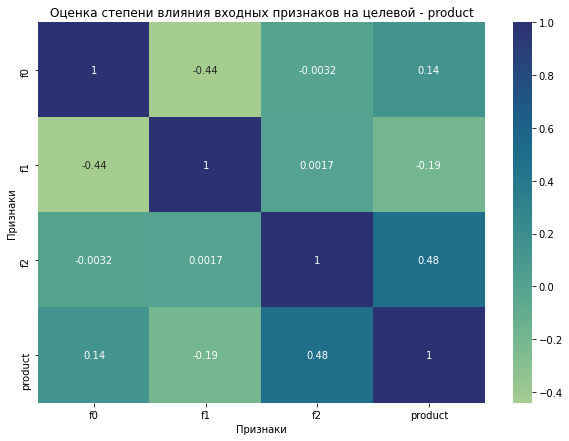

In [10]:
# построим тепловую карту для оценки степени влияния входных признаков на целевой - product
ax = sns.heatmap(geo_data_0.corr(), annot=True, cmap='crest')
ax.set_title('Оценка степени влияния входных признаков на целевой - product')
ax.set_xlabel('Признаки')
ax.set_ylabel('Признаки')
plt.show()

**Самым значимым** входным признаком для целевого **является f2**, который как раз и имеет нормальное распределение.    
Продолжим исследование и определим зависимости на двух других наборах данных.

In [11]:
# исследуем данные в наборе geo_data_1
display(geo_data_1.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


В наборе **geo_data_1** данные тоже не вызывают вопросов:    
- данные показателя **f0** принимают значения от **-31.609576 до 29.421755**;
- данные показателя **f1** принимают значения от **-26.358598 до 18.734063**;
- данные показателя **f2** принимают значения от **-0.018144 до 5.019721**;
- данные показателя **product** принимают значения от **0.000000 до 137.945408**.    

Дополнительно можно отметить, что данные набора **geo_data_1** имеют значения в полях **f0** и **f1** в **30 раз превышающие** аналогичные показатели набора **geo_data_0**, а в поле **f2**, который влиял на целевой признак, наоборот - **меньше** аналогичных в **geo_data_0** в **3 раза**.
В каких-то скважинах объем запасов нефти также равен 0.     
Построим графики распределения величин, чтобы визуально проверить наличие аномалий.

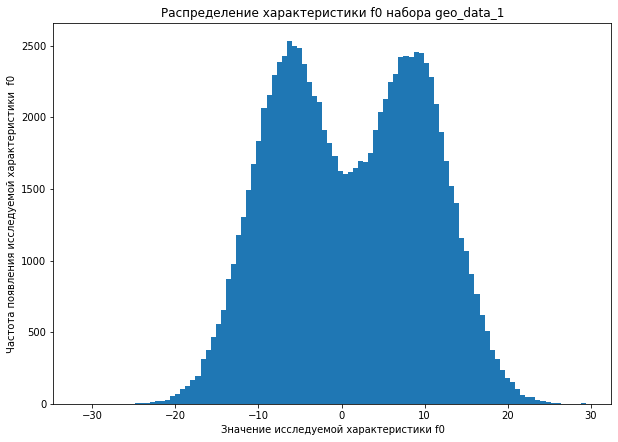

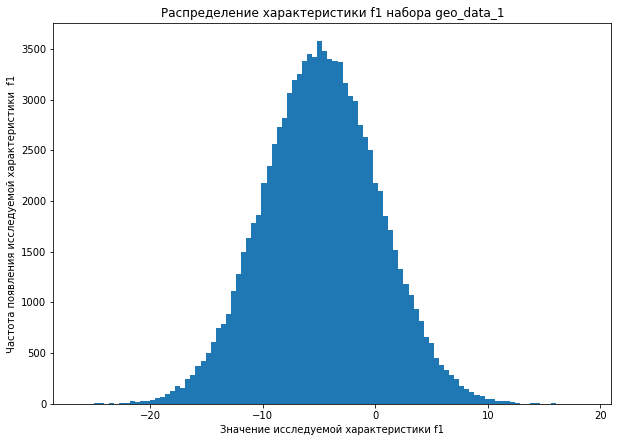

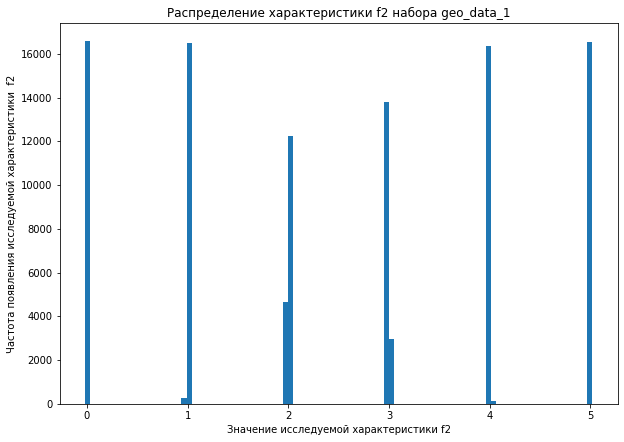

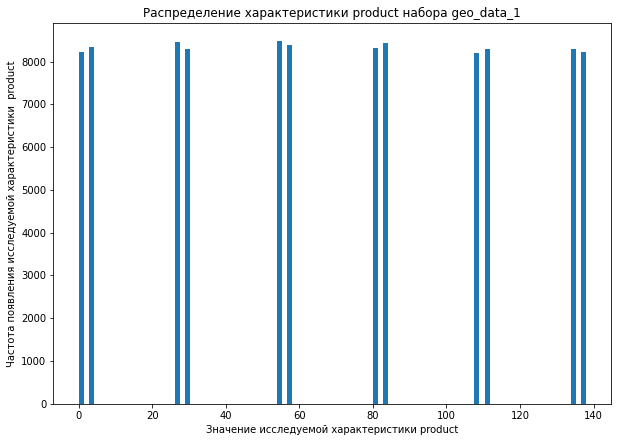

In [12]:
for i in geo_data_1.select_dtypes('float64'):
    ax = geo_data_1[i].plot(kind='hist', bins=100)
    ax.set_title(f'Распределение характеристики {i} набора geo_data_1')
    ax.set_xlabel(f'Значение исследуемой характеристики {i}')
    ax.set_ylabel(f'Частота появления исследуемой характеристики  {i}')
    plt.show()

Из полученных графиков видно:    
- только признак **f1** имеет приемлемое нормальное распределение;
- признаки **f2** и **product** содержат дискретные значения;
- признак **f0** имеет волнообразное распределение (*несколько наборов наблюдений свели в один набор?*).

Признаки изменили свое распределение, если сравнивать наборы данных geo_data_0 и geo_data_1.
Признак f2 набора geo_data_0 заменил признак f1 набора geo_data_1. Но также подтверждается версия, что признак product является категориальным признаком.

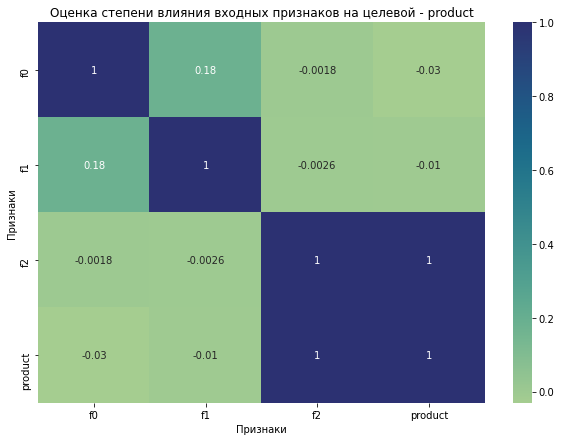

In [13]:
# построим тепловую карту для оценки степени влияния входных признаков на целевой - product
ax = sns.heatmap(geo_data_1.corr(), annot=True, cmap='crest')
ax.set_title('Оценка степени влияния входных признаков на целевой - product')
ax.set_xlabel('Признаки')
ax.set_ylabel('Признаки')
plt.show()

Что же мы видим? Что у признаков f2 и product высокая корреляция.  
Оставшиеся признаки f0 и f1 вообще не коррелируют с целевым признаком.

In [14]:
# исследуем данные в наборах на наличие выбросов, а также определим их взаимосвязи
display(geo_data_2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Данные в наборе geo_data_2, как и все предыдущие, на первый взгляд не имеют аномалий:    
- данные показателя **f0** принимают значения от **-8.760004 до 7.238262**;
- данные показателя **f1** принимают значения от **-7.084020 до 7.844801**;
- данные показателя **f2** принимают значения от **-11.970335 до 16.739402**;
- данные показателя **product** принимают значения от **0.000000 до 190.029838**.    

Дополнительно можно отметить, что данные набора **geo_data_1** имеют значения в полях **f0** и **f1** ,**превышающие** аналогичные показатели набора **geo_data_0**, приблизительно **в 4 раза**, а в поле **f2**, который влиял на целевой признак, **все в порядке**, данные соотносятся друг с другом. В каких-то скважинах объем запасов нефти также равен 0.
Построим графики распределения величин, чтобы визуально проверить наличие аномалий.

In [15]:
display(geo_data_0.agg(['min','max']))
display(geo_data_1.agg(['min','max']))
display(geo_data_2.agg(['min','max']))

,id,f0,f1,f2,product
min,006OJ,-1.408605,-0.848218,-12.088328,0.000000
max,zzzLH,2.362331,1.343769,16.003790,185.364347


,id,f0,f1,f2,product
min,0022J,-31.609576,-26.358598,-0.018144,0.000000
max,zzzvI,29.421755,18.734063,5.019721,137.945408


,id,f0,f1,f2,product
min,009Gl,-8.760004,-7.084020,-11.970335,0.000000
max,zzz9h,7.238262,7.844801,16.739402,190.029838


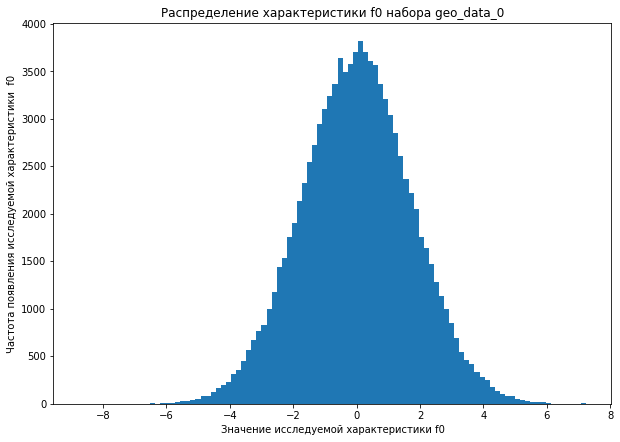

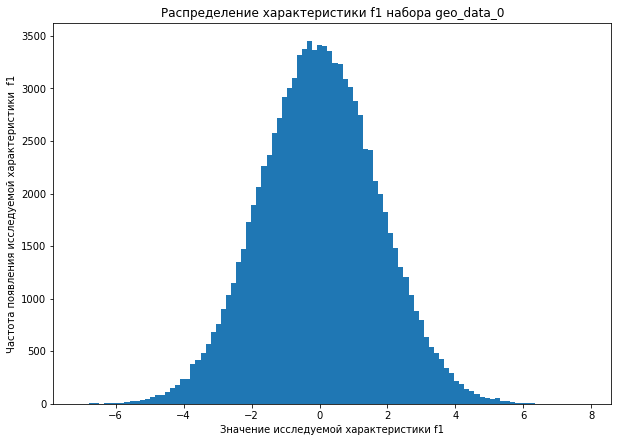

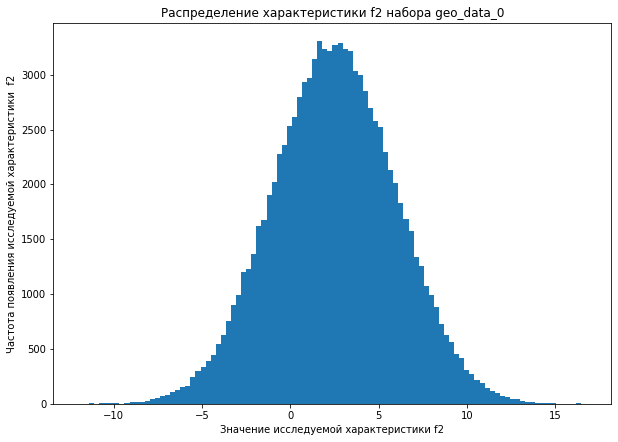

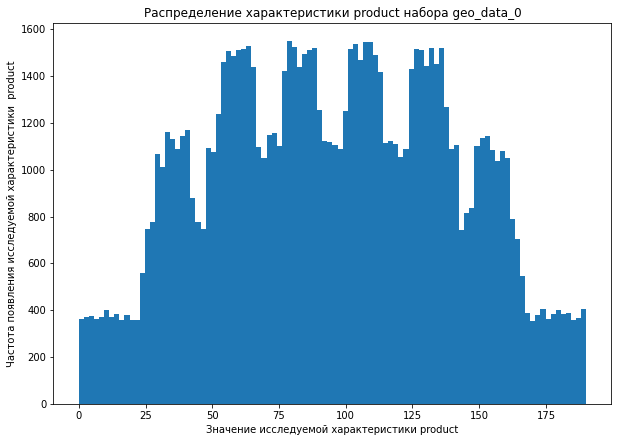

In [16]:
for i in geo_data_2.select_dtypes('float64'):
    ax = geo_data_2[i].plot(kind='hist', bins=100)
    ax.set_title(f'Распределение характеристики {i} набора geo_data_0')
    ax.set_xlabel(f'Значение исследуемой характеристики {i}')
    ax.set_ylabel(f'Частота появления исследуемой характеристики  {i}')
    plt.show()

Из полученных графиков видно:    
- признаки **f0**, **f1**, **f2** имеют нормальное распределение;
- признак **product** скорее имеет нормальное распределение, но с ярко выраженными пиками, как и в наборе geo_data_2 (*категориальные данные?*).

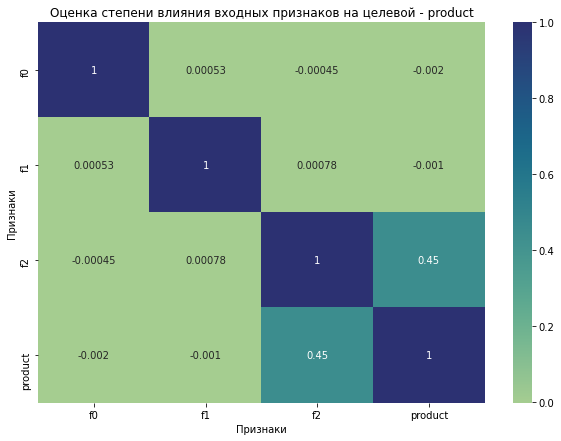

In [17]:
# построим тепловую карту для оценки степени влияния входных признаков на целевой - product
ax = sns.heatmap(geo_data_2.corr(), annot=True, cmap='crest')
ax.set_title('Оценка степени влияния входных признаков на целевой - product')
ax.set_xlabel('Признаки')
ax.set_ylabel('Признаки')
plt.show()

Самым значимым входным признаком для целевого в наборе geo_data_2 является **f2**.       
Эти данные соответствуют выводам по первому набору данных **geo_data_0**.

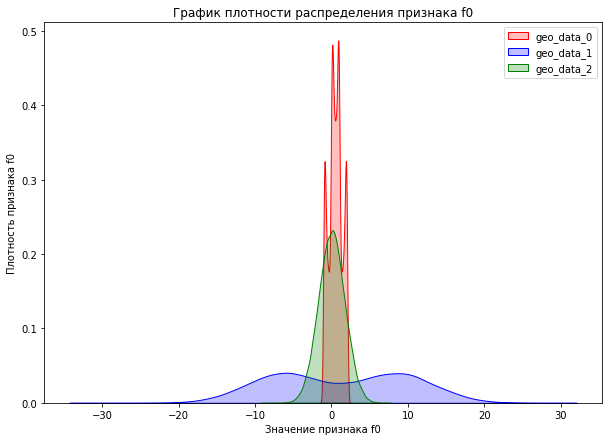

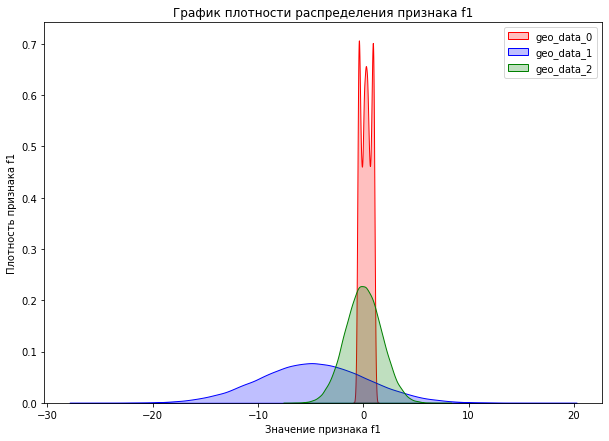

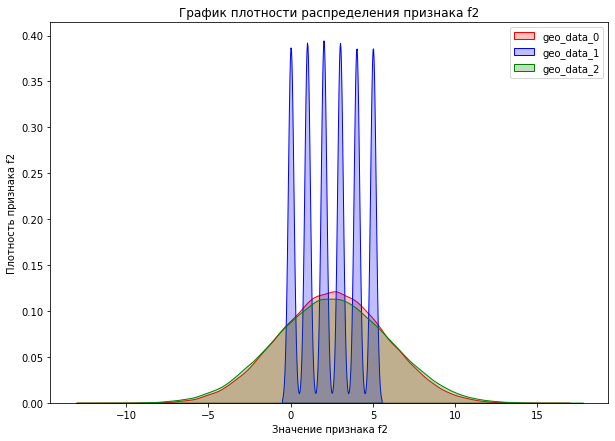

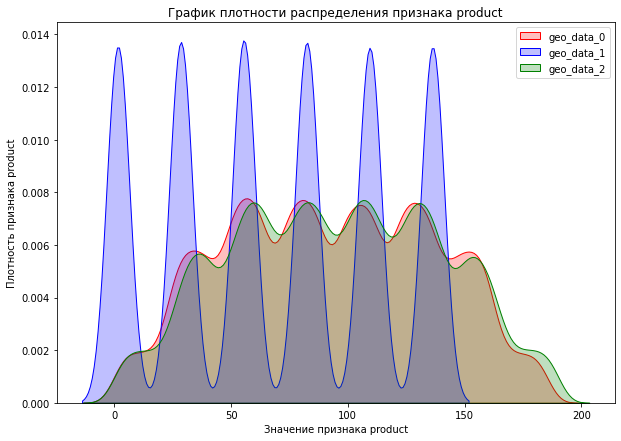

In [18]:
# посмотрим, как одинаковые признаки соотносятся между регионами. Отобразим данные на графике плотности
for i in geo_data_0.select_dtypes('float64'):
    ax = sns.kdeplot(geo_data_0[i], shade = True, color='red', label = f'geo_data_0')
    sns.kdeplot(geo_data_1[i], shade = True, color='blue', label = f'geo_data_1')
    sns.kdeplot(geo_data_2[i], shade = True, color='green', label = f'geo_data_2')
    ax.set_title(f'График плотности распределения признака {i}')
    ax.set_xlabel(f'Значение признака {i}')
    ax.set_ylabel(f'Плотность признака {i}')
    ax.legend(loc ='upper right')
    plt.show()

**Вывод по результатам исследовательского анализа данных**:
- самый адекватный набор данных - **geo_data_2**, в нем:
    - все входные признаки имеют нормальное распределение,
    - целевой признак product похож на категориальный,
    - самая высокая корреляция между входным и целевым признаком у f2;
- следующий по адекватности - **geo_data_1**, в нем:
    - только входной признак f1 имеет нормальное распределение;
    - входной f2 и целевой product содержат дискретные значения;
    - входной признак f2 имееют очень высокую корреляцию (1) с целевым;
    - входной признак f0 имеет 2 холма в распределении;
- самый странный набор - **geo_data_0**, в нем:
    - только входной признак f2 имеет нормальное распределение;
    - входной признак f0 имеет 4 холма, f1 - 3 холма в распределении;
    - целевой признак product похож на категориальный,;
    - самая высокая корреляция между входным и целевым признаком у f2;

## Обучение и проверка модели

Напишем функцию для подготовки данных для обучения модели

In [19]:
# задаем размер валидационной выборки и значение RANDOM_STATE для всех наборов данных
TEST_SIZE = 0.25
RANDOM_STATE=42

In [20]:
# создаем функцию для обучения модели
def prep_data(geodata: pd.DataFrame,
              target_col_name: str,
              drop_col_names: list,
              qnt_col_names: list,
              RANDOM_STATE: int,
              TEST_SIZE: float
             ):
    # выделяем целевой признак из данных
    X_0 = geodata.drop(drop_col_names, axis=1)
    y_0 = geodata[target_col_name]

    # делим выборку geo_data_0 на обучающую и валидационную
    X_train, X_test, y_train, y_test = train_test_split(
            X_0, 
            y_0, 
            random_state=RANDOM_STATE,
            test_size=TEST_SIZE
        )

    # масштабируем количественные признаки с помощью StandardScaler.
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[qnt_col_names])
    X_test_scaled = scaler.transform(X_test[qnt_col_names]) 
    df_train_scaled = pd.DataFrame(X_train_scaled, columns=qnt_col_names)
    df_test_scaled = pd.DataFrame(X_test_scaled, columns=qnt_col_names)
    
    # инициализируем модель линейной регрессии
    model_lr  = LinearRegression()

    # обучаем модель
    model_lr.fit(df_train_scaled, y_train)  

    # формируем предсказания на валидационной выборке
    y_pred = model_lr.predict(df_test_scaled) 

    return y_test, y_pred

In [21]:
# создаем функцию для расчета характеристик модели
def geo_data_metrics(model_geo_data):
    # оцениваем качество модели на тестовой выборке, рассчитываем RMSE модели
    rmse = round(mean_squared_error(model_geo_data[0], model_geo_data[1])**0.5,3)

    # рассчитываем разницу (ошибку) между реальным и предсказанным значением в %
    delta_test_pred = round(100*(model_geo_data[1].sum() - model_geo_data[0].sum())/model_geo_data[1].sum(),2)
    
    # рассчитываем средний запас сырья в одной скважине по предсказаниям модели
    raw_material_mean = round(model_geo_data[1].sum()/len(model_geo_data[1]),3)
    
    return rmse, delta_test_pred, raw_material_mean

In [22]:
# обучаем модель на данных 0 региона - geo_data_0
model_geo_data_0 = prep_data(
    geo_data_0,
    'product',
    ['id','product'],
    ['f0', 'f1', 'f2'],
    RANDOM_STATE,
    TEST_SIZE    
)

In [23]:
# обучаем модель на данных 1 региона - geo_data_1
model_geo_data_1 = prep_data(
    geo_data_1,
    'product',
    ['id','product'],
    ['f0', 'f1', 'f2'],
    RANDOM_STATE,
    TEST_SIZE    
)

In [24]:
# обучаем модель на данных 2 региона - geo_data_2
model_geo_data_2 = prep_data(
    geo_data_2,
    'product',
    ['id','product'],
    ['f0', 'f1', 'f2'],
    RANDOM_STATE,
    TEST_SIZE    
)

In [25]:
# проводим оценку построения модели и дополнительные расчеты
stat_0 = geo_data_metrics(model_geo_data_0)
stat_1 = geo_data_metrics(model_geo_data_1)
stat_2 = geo_data_metrics(model_geo_data_2)

In [26]:
# выводим на экран результаты оценки и расчетов
print(f'RMSE модели geo_data_0: {stat_0[0]}, занижение объемов на {stat_0[1]}%, ср.запас сырья в 1 скважине: {stat_0[2]}')
print(f'RMSE модели geo_data_1: {stat_1[0]}, завышение объемов на {-stat_1[1]}%, ср.запас сырья в 1 скважине: {stat_1[2]}')
print(f'RMSE модели geo_data_2: {stat_2[0]}, завышение объемов на {-stat_2[1]}%, ср.запас сырья в 1 скважине: {stat_2[2]}')

RMSE модели geo_data_0: 37.757, занижение объемов на 0.08%, ср.запас сырья в 1 скважине: 92.399
RMSE модели geo_data_1: 0.89, завышение объемов на 0.02%, ср.запас сырья в 1 скважине: 68.713
RMSE модели geo_data_2: 40.146, завышение объемов на 0.4%, ср.запас сырья в 1 скважине: 94.771


**Вывод по результатам обучения моделей**:
- модель линейной регрессии, обученная на данных для 0-го региона:
    - показала ошибку RMSE =  37.757,
    - предсказанный объем оказался меньше реального на 0,08%;
    - средний запас сырья в 1 скважине = 92,399 тыс.баррелей;
- модель линейной регрессии, обученная на данных для 1-го региона:
    - показала ошибку RMSE =  0.89,
    - предсказанный объем оказался больше реального на 0,02%;
    - средний запас сырья в 1 скважине = 68.713 тыс.баррелей;
- модель линейной регрессии, обученная на данных для 2-го региона:
    - показала ошибку RMSE =  40.146,
    - предсказанный объем оказался больше реального на 0,4%;
    - средний запас сырья в 1 скважине = 94,771 тыс.баррелей.
    
По показателям в лидерах оказалась модель, построенная для 0-го региона.

## Подготовка к расчёту прибыли

**Исходные условия:**
1. При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.    
2. Бюджет на разработку скважин в регионе — 10 млрд рублей.    
3. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [27]:
# запишем исходные требования к скважинам в переменные
BOREHOLES = 500
BEST_BOREHOLES = 200
BUDGET = 10000000000
BUDGET_MLRD = 10
PROFIT_RUB_PER_BARREL = 450
PROFIT_RUB_PER_1000BARREL = 450000

In [28]:
# рассчитаем запас сырья, который должен быть в одной скважине, чтобы выйти в 0
raw_material_per_borehole = (BUDGET/PROFIT_RUB_PER_1000BARREL)/BEST_BOREHOLES

print(f'Необходимый запас сырья в одной скважине для безубыточной разработки: \
    {round(raw_material_per_borehole, 0)} тыс.баррелей')

Необходимый запас сырья в одной скважине для безубыточной разработки:     111.0 тыс.баррелей


In [29]:
# рассчитываем имеющийся запас сырья в регионах
raw_material_per_borehole_fact_0 = round(geo_data_0['product'].sum()/len(geo_data_0),2)
raw_material_per_borehole_fact_1 = round(geo_data_1['product'].sum()/len(geo_data_1),2)
raw_material_per_borehole_fact_2 = round(geo_data_2['product'].sum()/len(geo_data_2),2)

In [30]:
# выводим рассчитанные показатели запасов сырья в регионах
print(raw_material_per_borehole_fact_0)
print(raw_material_per_borehole_fact_1)
print(raw_material_per_borehole_fact_2)

92.5
68.83
95.0


In [31]:
# выводим на экран дельту между требуемым запасом и имеющимся
print(f'Разница в запасах сырья для 0-го региона: \
    {round(raw_material_per_borehole_fact_0-raw_material_per_borehole,2)} тыс.баррелей')
print(f'Разница в запасах сырья для 1-го региона: \
    {round(raw_material_per_borehole_fact_1-raw_material_per_borehole,2)} тыс.баррелей')
print(f'Разница в запасах сырья для 2-го региона: \
    {round(raw_material_per_borehole_fact_2-raw_material_per_borehole,2)} тыс.баррелей')

Разница в запасах сырья для 0-го региона:     -18.61 тыс.баррелей
Разница в запасах сырья для 1-го региона:     -42.28 тыс.баррелей
Разница в запасах сырья для 2-го региона:     -16.11 тыс.баррелей


In [32]:
# подсчитаем количество скважин, в которых объем сырья не меньше требуемого для безубыточной добычи
good_boreholes_0 = geo_data_0[geo_data_0['product']>=raw_material_per_borehole]['product'].count()
good_boreholes_1 = geo_data_1[geo_data_1['product']>=raw_material_per_borehole]['product'].count()
good_boreholes_2 = geo_data_2[geo_data_2['product']>=raw_material_per_borehole]['product'].count()

In [33]:
# выведем количество подходящих скважин в каждом регионе
print(f'Хороших скважин в 0-м регионе: {good_boreholes_0} штук')
print(f'Хороших скважин в 1-м регионе: {good_boreholes_1} штук')
print(f'Хороших скважин в 2-м регионе: {good_boreholes_2} штук')

Хороших скважин в 0-м регионе: 36583 штук
Хороших скважин в 1-м регионе: 16537 штук
Хороших скважин в 2-м регионе: 38178 штук


In [34]:
# выведем процент подходящих под заданные условия скважин в каждом регионе
print(f'% хороших скважин в 0-м регионе (более 111 тыс.баррелей) : {round(100*good_boreholes_0/len(geo_data_0),1)}')
print(f'% хороших скважин в 1-м регионе (более 111 тыс.баррелей) : {round(100*good_boreholes_1/len(geo_data_1),1)}')
print(f'% хороших скважин во 2-м регионе (более 111 тыс.баррелей) : {round(100*good_boreholes_2/len(geo_data_2),1)}')

% хороших скважин в 0-м регионе (более 111 тыс.баррелей) : 36.6
% хороших скважин в 1-м регионе (более 111 тыс.баррелей) : 16.5
% хороших скважин во 2-м регионе (более 111 тыс.баррелей) : 38.2


**Выводы по результатам подготовки к расчету прибыли**:     

Необходимый запас сырья в одной скважине должен составлять 111 тыс.баррелей, чтобы добыча была безубыточной.    
По средним показателям все представленные регионы получились убыточными.    
Однако по количеству скважин с запасами более требуемого лидирует 2-й регион (38.2%).

## Расчёт прибыли и рисков 

In [35]:
# создаем функцию для расчета прибыли по 200-м скважинам с лучшими запасами сырья
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return selected.sum() * PROFIT_RUB_PER_1000BARREL/1000000000 - BUDGET_MLRD

In [36]:
# создаем функцию для использования техники Bootstrap для 1000 выборок
# формируем набор прибылей, рассчитываем границы доверительного интервала и риск убытков в %
def make_stats(model_geo_data):
    state = np.random.RandomState(12345)
    df_true = pd.Series(model_geo_data[0].reset_index(drop=True))
    df_pred = pd.Series(model_geo_data[1]).reset_index(drop=True)
    values = []
    for i in range(1000):  
        target_subsample = df_true.sample(n=BOREHOLES, replace = True, random_state = state)
        probs_subsample = df_pred.iloc[target_subsample.index]
        res = revenue(target_subsample,probs_subsample, BEST_BOREHOLES)
        values.append(res)    
    values = pd.Series(values)
    lower = round(values.quantile(0.025),2)
    upper = round(values.quantile(0.975),2)
    risk = round(values[values<=0].count()/len(values)*100,3)
    return values, lower, upper, risk

In [37]:
# сохраним значения расчетных метрик по скважинам для каждого региона в переменную stats
stats_0 = make_stats(model_geo_data_0) 
stats_1 = make_stats(model_geo_data_1)   
stats_2 = make_stats(model_geo_data_2)   

In [38]:
# сохраним значения расчетных метрик прибыли по скважинам для каждого региона в переменную values
values_0 = stats_0[0] 
values_1 = stats_1[0] 
values_2 = stats_2[0] 

In [39]:
# вычисляем доверительный интервал для каждого региона (95%)
lower_0 = stats_0[1] 
upper_0 = stats_0[2] 
lower_1 = stats_1[1] 
upper_1 = stats_1[2] 
lower_2 = stats_2[1] 
upper_2 = stats_2[2] 

In [40]:
# вычисляем риски для каждого региона
risk_0 = stats_0[3] 
risk_1 = stats_1[3] 
risk_2 = stats_2[3] 

In [41]:
print(f"Ср.выручка с месторождений в 0-м регионе: {round(values_0.mean(),2)} млрд.руб. c 95%-ным дов.интервалом: \
[{lower_0} ; {upper_0}] и риском убытков: {risk_0}%")
print(f"Ср.выручка с месторождений в 1-м регионе: {round(values_1.mean(),2)} млрд.руб. c 95%-ным дов.интервалом: \
[{lower_1} ; {upper_1}] и риском убытков: {risk_1}%")
print(f"Ср.выручка с месторождений во 2-м регионе: {round(values_2.mean(),2)} млрд.руб. c 95%-ным дов.интервалом: \
[{lower_2} ; {upper_2}] и риском убытков: {risk_2}%")

Ср.выручка с месторождений в 0-м регионе: 0.44 млрд.руб. c 95%-ным дов.интервалом: [-0.12 ; 0.97] и риском убытков: 6.1%
Ср.выручка с месторождений в 1-м регионе: 0.49 млрд.руб. c 95%-ным дов.интервалом: [0.06 ; 0.91] и риском убытков: 1.1%
Ср.выручка с месторождений во 2-м регионе: 0.4 млрд.руб. c 95%-ным дов.интервалом: [-0.15 ; 0.95] и риском убытков: 7.1%


**Вывод по результатам расчета прибыли и рисков**:
- мы применили метод Bootstrap для формирования 1000 различных выборок из 200 скважин для каждого месторождения;
- рассчитали размер прибыли и риск убытков в % для каждого месторождения на основе 1000 случайных выборок;   

По итогу 1-е место занял 1-й регион со максимальным показателем прибыли месторождения и минимальным риском убытков:
- Ср.выручка с месторождений в 1-м регионе: 0.49 млрд.руб. c 95%-ным дов.интервалом: [0.06 ; 0.91] и риском убытков: 1.1%

## Заключительные выводы

Перед нами стояла задача выбрать наиболее прибыльный регион для разработки месторождений с помощью модели МО.   

Для этого мы проделали следующую работу:
- проанализировали данные, полученные от заказчика с данными по скважинам из 3-х регионов:
    - данные не содержали аномальных значений, отсутствовали пропуски;
- провели их предобработку и анализ:
    - в наборе 0-го региона входные признаки f0, f1 имеют несколько холмов в распределении,
      признак f2 имеет нормальное распределение, самая высокая корреляция с целевым признаком у f2 (0.48);  
    - в наборе 1-го региона входной признак имеет 2 холма в распределении, входной признак f1 имеет нормальное распределение,
      признаки f2 и product(целевой) содержат дискретные значения, очень высокая корреляция с целевым признаком у f2(1);
    - набор 2-го региона был самым адекватным: все выходные признаки меют нормальное распределение, самая высокая корреляция
      с целевым признаком у f2 (0.45)
    2-й регион должен показать наиболее достоверные результаты.
- выбрали для обучения модель линейного регрессии и обучили 3 модели предсказывать запасы сырья в скважинах каждого региона:
    - значение метрик в 0-м регионе:
        - RMSE = 37.757;
        - предсказанный моделью объем оказался меньше реального на 0,08%;
        - средний запас сырья в 1 скважине = 92,399 тыс.баррелей;
    - значение метрик в 1-м регионе:
        - RMSE = 0.89;
        - предсказанный моделью объем оказался больше реального на 0,02%;
        - средний запас сырья в 1 скважине = 68,713 тыс.баррелей;
    - значение метрик в 2-м регионе:
        - RMSE = 40.146;
        - предсказанный моделью объем оказался больше реального на 0,4%;
        - средний запас сырья в 1 скважине = 94,771 тыс.баррелей;     
    таким образом, первенство перехватил 0-й регион;
- провели предварительные расчеты по данным регионов с использованием построенных моеделй МО:
    - рассчитали необходимый запас сырья в каждой скважине, чтобы считать ее безубыточной (111 тыс.баррелей);
    - определили количество скважин, в которых запасов больше порогового значения, в лидерах оказался 2-й регион (38.2%);
    - подсчитали средний объем запасов на 1 скважину и сделали вывод, что по этому показателю все регионы убыточны;    
- с помощью обученных моделей, используя метод Bootstrap для 1000 разных выборок из 200 скважин:
    - рассчитали размер прибыли;
    - рассчитали размер убытков;
    - построили доверительный интервал для прибыли.
    
**Вывод: первое место у 1-го региона (geo_data_1)**     

- максимальный показатель прибыли месторождения (0,49 млрд.рублей с 95%-ным дов.интервалом: [0.06 ; 0.91]);
- минимальный риск убытков (1.1%).